## zeroshot integration

#### Here we use the lung dataset (https://figshare.com/ndownloader/files/24539942) in SCIB (doi.org/10.1038/s41592-021-01336-8)

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3" ## set your available devices, each use ~2G GPU-MEMORY
import scanpy as sc

In [2]:
import scMulan

In [3]:
from scMulan import GeneSymbolUniform

## 1. load h5ad
It's recommended that you use h5ad here with raw count (and after your QC)

In [4]:
adata = sc.read(
    "Data/lung_atlas.h5ad",
    backup_url="https://figshare.com/ndownloader/files/24539942",
)

In [5]:
adata

AnnData object with n_obs × n_vars = 32472 × 15148
    obs: 'dataset', 'location', 'nGene', 'nUMI', 'patientGroup', 'percent.mito', 'protocol', 'sanger_type', 'size_factors', 'sampling_method', 'batch', 'cell_type', 'donor'
    layers: 'counts'

## 2. transform original h5ad with uniformed genes (42117 genes)

In [6]:
adata_GS_uniformed = GeneSymbolUniform(input_adata=adata,
                                 output_dir="Data/",
                                 output_prefix='lung')

The shape of query data is: (32472, 15148)
The length of reference gene_list is: 42117
Performing gene symbol uniform, this step may take several minutes


Processing: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15148/15148 [00:12<00:00, 1238.62it/s]


Building output data, this step may take several minutes


Processing: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13972/13972 [00:07<00:00, 1758.63it/s]


Shape of output data is (32472, 42117). It should have 42117 genes with cell number unchanged.
h5ad file saved in:/home/bianhaiyang/projects/cellgpt_v1/tools/scMulan_package/Data/lung_uniformed.h5ad
report file saved in: /home/bianhaiyang/projects/cellgpt_v1/tools/scMulan_package/Data/lung_report.csv


## 3. process uniformed data (simply norm and log1p)

In [7]:
## you can read the saved uniformed adata

#adata_GS_uniformed=sc.read_h5ad('Data/lung_uniformed.h5ad')

In [8]:
adata_GS_uniformed

AnnData object with n_obs × n_vars = 32472 × 42117
    obs: 'dataset', 'location', 'nGene', 'nUMI', 'patientGroup', 'percent.mito', 'protocol', 'sanger_type', 'size_factors', 'sampling_method', 'batch', 'cell_type', 'donor'

In [9]:
# norm and log1p, if adata is count matrix
if adata_GS_uniformed.X.max() > 10:
    sc.pp.normalize_total(adata_GS_uniformed, target_sum=1e4) 
    sc.pp.log1p(adata_GS_uniformed)

## 4. load scMulan

In [10]:
# you should first download ckpt from https://cloud.tsinghua.edu.cn/f/2250c5df51034b2e9a85/?dl=1
# put it under .ckpt/ckpt_scMulan.pt
# by: wget https://cloud.tsinghua.edu.cn/f/2250c5df51034b2e9a85/?dl=1  -O ckpt/ckpt_scMulan.pt

ckp_path = 'ckpt/ckpt_scMulan.pt'

In [11]:
scml = scMulan.model_inference(ckp_path, adata_GS_uniformed)
base_process = scml.cuda_count()

number of parameters: 368.80M


/home/bianhaiyang/anaconda3/envs/cellgpt/lib/python3.9/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


✅ adata passed check
👸 scMulan is ready
scMulan is currently available to 4 GPUs.


In [12]:
scml.get_cell_types_and_embds_for_adata(parallel=True, n_process = base_process) #set parallel = False to use single GPU

adata is not sparse, use dense matrix and dataframe
⚡ Speed up by multiprocessing with 4 processes and 4 GPUs...


⏳ Generating cell type labels and embds for each cell on device 0: 100%|██████████| 8118/8118 [03:52<00:00, 34.88it/s]
⏳ Generating cell type labels and embds for each cell on device 1: 100%|██████████| 8118/8118 [06:23<00:00, 21.17it/s]
⏳ Generating cell type labels and embds for each cell on device 2: 100%|██████████| 8118/8118 [07:14<00:00, 18.67it/s]
⏳ Generating cell type labels and embds for each cell on device 3: 100%|██████████| 8118/8118 [07:39<00:00, 17.65it/s]


The predicted cell types are stored in scml.adata.obs['cell_type_from_scMulan'], besides the cell embeddings (for multibatch integration) in scml.adata.obsm['X_scMulan'].

## 5. visualization

In [13]:
adata_embds = sc.AnnData(scml.adata.obsm['X_scMulan'].copy())
adata_embds.obs = scml.adata.obs

In [14]:
adata_embds

AnnData object with n_obs × n_vars = 32472 × 1120
    obs: 'dataset', 'location', 'nGene', 'nUMI', 'patientGroup', 'percent.mito', 'protocol', 'sanger_type', 'size_factors', 'sampling_method', 'batch', 'cell_type', 'donor', 'cell_type_from_scMulan'

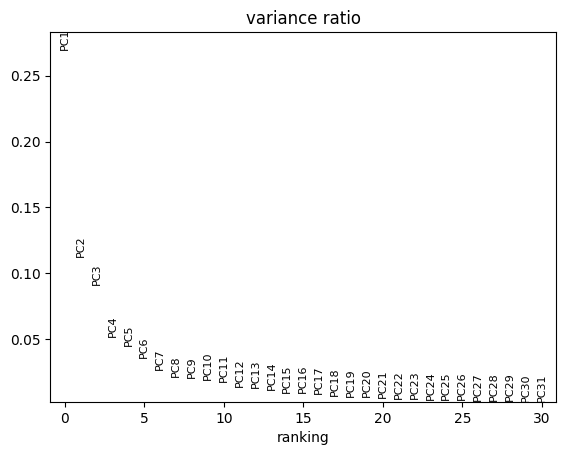

/home/bianhaiyang/anaconda3/envs/cellgpt/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/bianhaiyang/anaconda3/envs/cellgpt/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/bianhaiyang/anaconda3/envs/cellgpt/lib/python3.9/site-

In [15]:
sc.pp.pca(adata_embds)
sc.pl.pca_variance_ratio(adata_embds)
sc.pp.neighbors(adata_embds,n_pcs=12)
sc.tl.umap(adata_embds)

In [24]:
# you can run smoothing function to filter some false positives
scMulan.cell_type_smoothing(adata_embds, threshold=0.1)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32472/32472 [00:16<00:00, 1997.03it/s]
/home/bianhaiyang/projects/cellgpt_v1/tools/scMulan_package/scMulan/utils/utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs.cell_type_from_mulan_smoothing[adata.obs.smoothing_score<threshold] = "Unclassified"
/home/bianhaiyang/anaconda3/envs/cellgpt/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1208: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/home/bianhaiyang/anaconda3/envs/cellgpt/lib/python3.9/site-packages/scanpy/p

/home/bianhaiyang/anaconda3/envs/cellgpt/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1208: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/home/bianhaiyang/anaconda3/envs/cellgpt/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/bianhaiyang/anaconda3/envs/cellgpt/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/bianhaiyang/anaconda3/envs/cellgpt/lib/python3.9/site-packages/scanpy/plotti

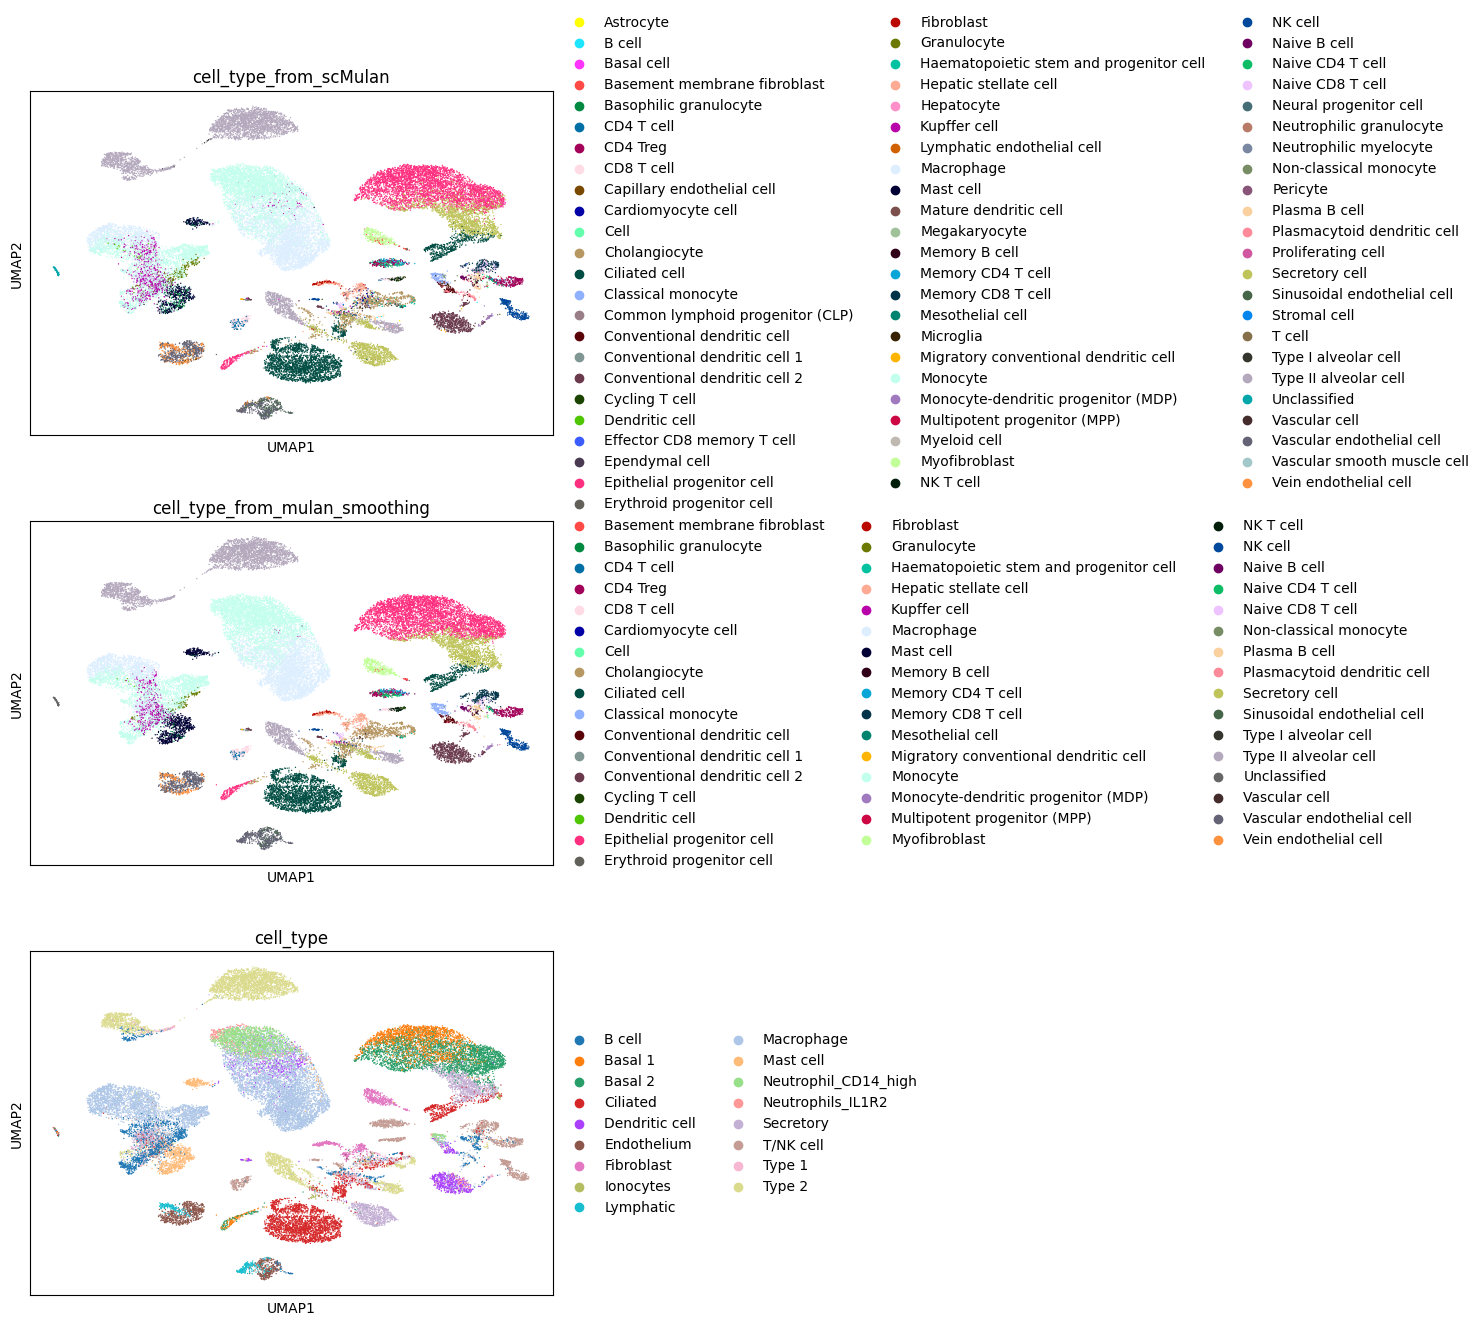

In [25]:
# cell_type_from_scMulan: pred
# cell_type_from_mulan_smoothing: mulan + smooth
# cell_type: original annotation

sc.pl.umap(adata_embds,color=["cell_type_from_scMulan","cell_type_from_mulan_smoothing",'cell_type'],ncols=1)

/home/bianhaiyang/anaconda3/envs/cellgpt/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1208: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/home/bianhaiyang/anaconda3/envs/cellgpt/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/bianhaiyang/anaconda3/envs/cellgpt/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


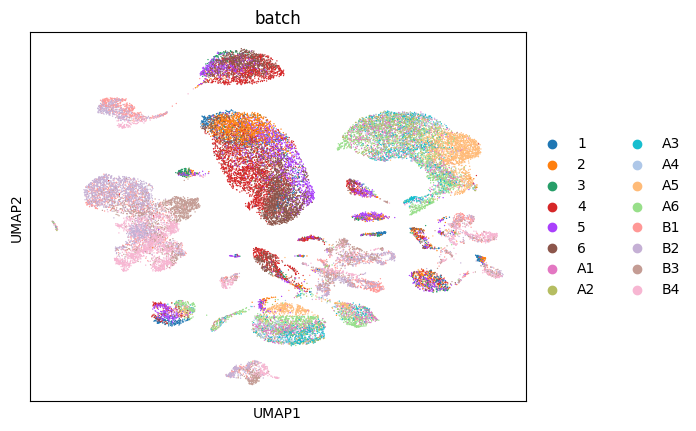

In [26]:
sc.pl.umap(adata_embds, color = ['batch'])